In [1]:
!pip install scikit-optimize
!pip install -U pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

Iteration No: 1 started. Evaluating function at random point.
Epoch 1/2
422/422 [==============================] - 79s 177ms/step - loss: 0.0301 - accuracy: 0.6941 - val_loss: 0.0151 - val_accuracy: 0.8135
Epoch 2/2
422/422 [==============================] - 56s 133ms/step - loss: 0.0155 - accuracy: 0.7775 - val_loss: 0.0151 - val_accuracy: 0.7953
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 138.4765
Function value obtained: 0.0152
Current minimum: 0.0152
Iteration No: 2 started. Evaluating function at random point.
Epoch 1/2
422/422 [==============================] - 54s 126ms/step - loss: 0.0615 - accuracy: 0.1256 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 2/2
422/422 [==============================] - 55s 130ms/step - loss: 0.0180 - accuracy: 0.1132 - val_loss: 0.0180 - val_accuracy: 0.1050
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 148.3713
Function value obtained: 0.0180
Current minimum: 0.0152
Iteration No: 3 started. Evaluatin

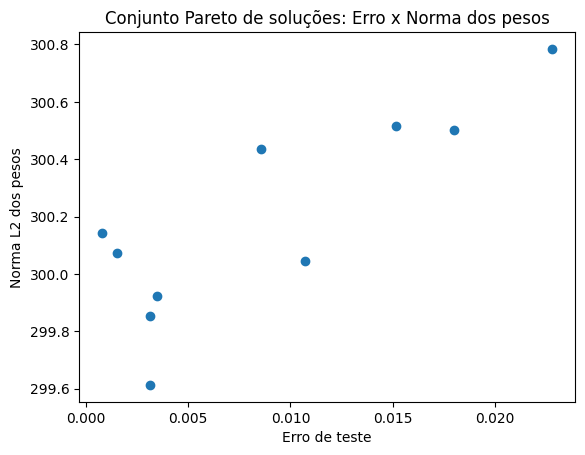

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from skopt import gp_minimize
import matplotlib.pyplot as plt

# Carregar os dados
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar os dados
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

def build_cnn_model():
    # Criar o modelo da rede neural convolucional
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    return model

def chebyshev_loss(y_true, y_pred, model, lambda1, lambda2):
    # Função de perda Categorical Crossentropy
    ce_loss = keras.losses.CategoricalCrossentropy()(y_true, y_pred)

    # Função de regularização L2
    l2_loss = sum([tf.nn.l2_loss(layer.kernel) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])

    # Combinar as funções de perda com os pesos de Chebyshev
    combined_loss = lambda1 * ce_loss + lambda2 * l2_loss

    return combined_loss

def objective(params):
    lambda1, lambda2 = params
    
    # Construir o modelo da CNN
    model = build_cnn_model()

    # Compilar o modelo com a função de perda personalizada e otimizador
    model.compile(loss=lambda y_true, y_pred: chebyshev_loss(y_true, y_pred, model, lambda1, lambda2), optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

    # Treinar o modelo
    model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1, verbose=1)

    # Avaliar o desempenho do modelo
    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score[0]

space = [(0.0001, 0.01, "uniform"), (0.0001, 0.01, "uniform")]

result = gp_minimize(func=objective, dimensions=space, n_calls=10, random_state=42, verbose=1)

#Imprimir os melhores hiperparâmetros encontrados
best_lambda1, best_lambda2 = result.x
print(f"Melhores hiperparâmetros encontrados: lambda1 = {best_lambda1}, lambda2 = {best_lambda2}")

#Construir e treinar o melhor modelo
best_model = build_cnn_model()
best_model.compile(loss=lambda y_true, y_pred: chebyshev_loss(y_true, y_pred, best_model, best_lambda1, best_lambda2),
optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
best_model.fit(x_train, y_train, batch_size=128, epochs=2, validation_split=0.1, verbose=1)

#Avaliar o melhor modelo
score = best_model.evaluate(x_test, y_test, verbose=1)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

#Função para calcular a norma L2 dos pesos do modelo
def calculate_l2_norm(model):
    l2_norm = sum([np.sum(np.square(layer.kernel.numpy())) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])
    return l2_norm

#Preparar os dados para o gráfico do conjunto Pareto
pareto_error_data = [objective(params) for params in result.x_iters]
pareto_norm_data = [calculate_l2_norm(build_cnn_model()) for params in result.x_iters]

#Criar o gráfico do conjunto Pareto
plt.scatter(pareto_error_data, pareto_norm_data)
plt.xlabel("Erro de teste")
plt.ylabel("Norma L2 dos pesos")
plt.title("Conjunto Pareto de soluções: Erro x Norma dos pesos")
plt.show()



Este código realiza a otimização bayesiana usando a função `gp_minimize` da biblioteca `scikit-optimize`. A otimização bayesiana é aplicada para encontrar os melhores valores de lambda1 e lambda2 para a função de perda Chebyshev.

Após a otimização, o código constrói e treina o melhor modelo com os melhores hiperparâmetros encontrados. Em seguida, o código calcula o erro de teste e a norma L2 dos pesos para cada solução no conjunto Pareto, gerando um gráfico de dispersão para visualizar essas soluções.


Epoch 1/2
422/422 [==============================] - 71s 164ms/step - loss: 0.0299 - accuracy: 0.7339 - val_loss: 0.0151 - val_accuracy: 0.8233
Epoch 2/2
422/422 [==============================] - 51s 121ms/step - loss: 0.0155 - accuracy: 0.7735 - val_loss: 0.0150 - val_accuracy: 0.8073
Epoch 1/2
422/422 [==============================] - 56s 131ms/step - loss: 0.0620 - accuracy: 0.1194 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 2/2
422/422 [==============================] - 53s 126ms/step - loss: 0.0180 - accuracy: 0.1132 - val_loss: 0.0180 - val_accuracy: 0.1050
Epoch 1/2
422/422 [==============================] - 55s 127ms/step - loss: 0.0170 - accuracy: 0.7313 - val_loss: 0.0086 - val_accuracy: 0.8265
Epoch 2/2
422/422 [==============================] - 52s 124ms/step - loss: 0.0088 - accuracy: 0.7779 - val_loss: 0.0085 - val_accuracy: 0.8222
Epoch 1/2
422/422 [==============================] - 53s 123ms/step - loss: 0.0356 - accuracy: 0.1203 - val_loss: 0.0107 - val_accuracy:

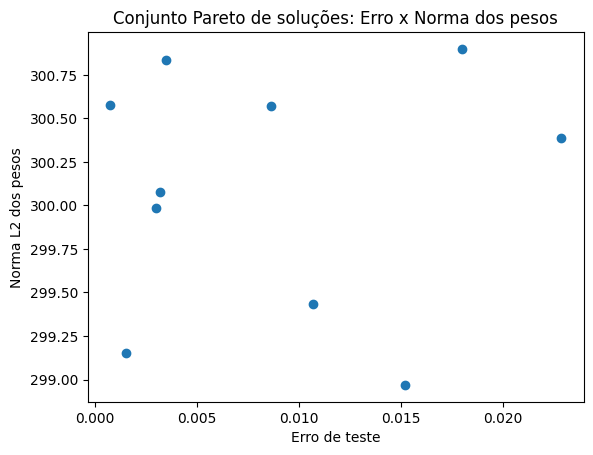

In [4]:
#Função para calcular a norma L2 dos pesos do modelo
def calculate_l2_norm(model):
    l2_norm = sum([np.sum(np.square(layer.kernel.numpy())) for layer in model.layers if 'Conv2D' in str(layer) or 'Dense' in str(layer)])
    return l2_norm

#Preparar os dados para o gráfico do conjunto Pareto
pareto_error_data = [objective(params) for params in result.x_iters]
pareto_norm_data = [calculate_l2_norm(build_cnn_model()) for params in result.x_iters]

#Criar o gráfico do conjunto Pareto
plt.scatter(pareto_error_data, pareto_norm_data)
plt.xlabel("Erro de teste")
plt.ylabel("Norma L2 dos pesos")
plt.title("Conjunto Pareto de soluções: Erro x Norma dos pesos")
plt.show()

In [5]:
model = build_cnn_model()
model.compile(loss=lambda y_true, y_pred: chebyshev_loss(y_true, y_pred, model, lambda1, lambda2), optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
weights = model.get_weights()

In [6]:
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 5, 5, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_51 (Flatten)        (None, 1600)              0         
                                                                 
 dense_102 (Dense)           (None, 128)             

In [19]:
layer_shapes = [l.weights[0].shape for l in model.layers if l.weights]
layer_shapes

[TensorShape([3, 3, 1, 32]),
 TensorShape([3, 3, 32, 64]),
 TensorShape([1600, 128]),
 TensorShape([128, 10])]

In [6]:
loss, _ = best_model.evaluate(x_test, y_test, verbose=False)
weights = best_model.get_weights()
norma = np.linalg.norm(np.concatenate([w.flatten() for w in weights]))

peso 1 -> 3 * 3 * 1 * 32 = 288 <br>
bias 1 -> 288 + 32 = 320 <br>
peso 2 -> 320 + 3 * 3 * 64 = 18752 <br>
bias 2 -> 18752 + 64 = 18816 <br>
peso 3 -> 18816 + 1600 * 128 = 223616 <br>
bias 3 -> 223616 + 128 = 223744 <br>
peso 4 -> 223744 + 128 * 10 = 225024 <br>
bias 4 -> 225024 + 10 = 225034

In [7]:
class NeuralNetworkProblem(Problem):

  def __init__(self, x_train, y_train):
    super().__init__(n_var=225034, n_obj=2, n_constr=0, xl=-1, xu=1)
    self.x_train = x_train
    self.y_train = y_train

  def _evaluate(self, x, out, *args, **kwargs):
    loss = []
    norma = []
    model = build_cnn_model()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    for linha in x:
      w1 = linha[:288].reshape(3, 3, 1, 32)
      b1 = linha[288: 320]
      w2 = linha[320: 18752].reshape(3, 3, 32, 64)
      b2 = linha[18752: 18816]
      w3 = linha[18816: 223616].reshape(1600, 128)
      b3 = linha[223616: 223744]
      w4 = linha[223744: 225024].reshape(128, 10)
      b4 = linha[225024: 225034]
      model.set_weights([w1, b1, w2, b2, w3, b3, w4, b4])

      l, a = model.evaluate(self.x_train, self.y_train, verbose=False)
      loss.append(l)
      norma.append(np.linalg.norm(linha))

      # Set the objectives
    out["F"] = np.column_stack([loss, norma])

In [8]:
problem = NeuralNetworkProblem(x_test, y_test)
algorithm = NSGA2(
    pop_size=50,
)
res = minimize(
    problem,
    algorithm,
    ("n_gen", 50),
    verbose=True,
    save_history=True,
    seed=1
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      3 |  0.6599118311 |         ideal
     3 |      150 |      5 |  0.6489645334 |         ideal
     4 |      200 |      7 |  0.0508204705 |         ideal
     5 |      250 |     12 |  0.2499783703 |         ideal
     6 |      300 |     13 |  0.1127055070 |         ideal
     7 |      350 |     13 |  0.0604292825 |         ideal
     8 |      400 |     16 |  0.0333790576 |         ideal
     9 |      450 |     13 |  0.0682700960 |         ideal
    10 |      500 |     16 |  0.0818575606 |         ideal
    11 |      550 |     13 |  0.0050280498 |             f
    12 |      600 |     13 |  0.0071834022 |             f
    13 |      650 |     22 |  0.0147387662 |             f
    14 |      700 |     21 |  0.0392124014 |         ideal
    15 |      750 |     30 |  0.0540823684 |         nadir
    16 |      800 |     35 |  0.0036705407 |            

KeyboardInterrupt: ignored

In [11]:
F = res.F
plt.scatter(F[:, 0], F[:, 1], color="red")
plt.scatter(loss, norma, color="blue" )

NameError: ignored

In [31]:
problem = NeuralNetworkProblem(x_test, y_test)
algorithm = NSGA2(
    pop_size=50,
)
res = minimize(
    problem,
    algorithm,
    ("n_gen", 50),
    verbose=True,
    save_history=True,
    seed=1
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      3 |  0.6599118311 |         ideal
     3 |      150 |      5 |  0.6489645334 |         ideal
     4 |      200 |      7 |  0.0508204705 |         ideal
     5 |      250 |     12 |  0.2499783703 |         ideal
     6 |      300 |     13 |  0.1127055070 |         ideal
     7 |      350 |     13 |  0.0604292825 |         ideal
     8 |      400 |     16 |  0.0333790576 |         ideal
     9 |      450 |     13 |  0.0682700960 |         ideal
    10 |      500 |     16 |  0.0818575606 |         ideal
    11 |      550 |     13 |  0.0050280498 |             f
    12 |      600 |     13 |  0.0071834022 |             f
    13 |      650 |     22 |  0.0147387662 |             f
    14 |      700 |     21 |  0.0392124014 |         ideal
    15 |      750 |     30 |  0.0540823684 |         nadir
    16 |      800 |     35 |  0.0036705407 |            

KeyboardInterrupt: ignored

In [33]:
res.F

array([[   2.42585373,  290.0269784 ],
       [2080.17529297,  258.76505007],
       [  48.17569351,  265.46576882],
       [ 921.23272705,  262.39629598],
       [   3.24718308,  272.86379252],
       [ 481.94329834,  265.43579288],
       [1880.92797852,  259.19366583],
       [1625.08459473,  260.0130075 ],
       [   3.0352819 ,  279.01281187],
       [   2.48910069,  284.38601802]])

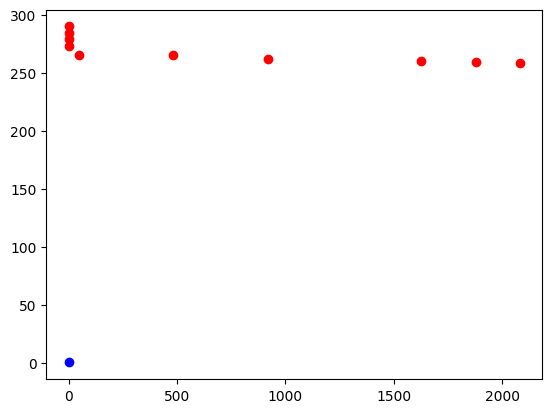

In [35]:
F = res.F
plt.scatter(F[:, 0], F[:, 1], color="red")
plt.scatter(loss, norma, color="blue" )

In [8]:
problem = NeuralNetworkProblem(x_test, y_test)
algorithm = NSGA2(
    pop_size=20
)
res = minimize(
    problem,
    algorithm,
    ("n_gen", 50),
    verbose=True,
    save_history=True,
    seed=1
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      5 |             - |             -
     2 |       40 |      4 |  0.9262496291 |         ideal
     3 |       60 |      4 |  0.8995018290 |         ideal
     4 |       80 |      7 |  0.1150146372 |         ideal
     5 |      100 |      9 |  0.3164504728 |         ideal
     6 |      120 |     11 |  0.4257024660 |         nadir
     7 |      140 |     11 |  0.1237480330 |         ideal
     8 |      160 |     12 |  0.0271887498 |             f
     9 |      180 |     12 |  0.0173615145 |         ideal
    10 |      200 |     18 |  0.0240532149 |             f
    11 |      220 |     17 |  0.0968207561 |         ideal
    12 |      240 |     20 |  0.0126506972 |         ideal
    13 |      260 |     20 |  0.0256175644 |             f
    14 |      280 |     20 |  0.0430016188 |         ideal
    15 |      300 |     20 |  0.1081903124 |         nadir
    16 |      320 |     20 |  0.0243057589 |            

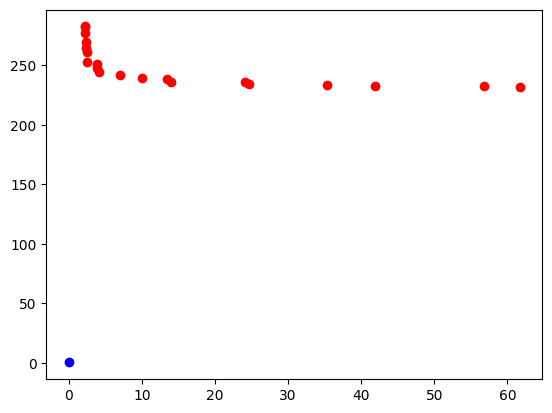

In [9]:
F = res.F
plt.scatter(F[:, 0], F[:, 1], color="red")
plt.scatter(loss, norma, color="blue" )